In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler

sns.set(style="whitegrid")

In [3]:
df_household = pd.read_csv('data.csv')

# Mostramos las primeras filas
print(df_household.head())

   Age Education_Level  Occupation  Number_of_Dependents Location  \
0   56        Master's  Technology                     5    Urban   
1   69     High School     Finance                     0    Urban   
2   46      Bachelor's  Technology                     1    Urban   
3   32     High School      Others                     2    Urban   
4   60      Bachelor's     Finance                     3    Urban   

   Work_Experience Marital_Status Employment_Status  Household_Size  \
0               21        Married         Full-time               7   
1                4         Single         Full-time               7   
2                1         Single         Full-time               7   
3               32        Married         Full-time               1   
4               15        Married     Self-employed               4   

  Homeownership_Status     Type_of_Housing  Gender  \
0                  Own           Apartment    Male   
1                  Own           Apartment    Male

##### ***EXPLORACIÓN DE DATOS***

In [4]:
# Visualizamos la información del dataset

df_household.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             10000 non-null  int64 
 1   Education_Level                 10000 non-null  object
 2   Occupation                      10000 non-null  object
 3   Number_of_Dependents            10000 non-null  int64 
 4   Location                        10000 non-null  object
 5   Work_Experience                 10000 non-null  int64 
 6   Marital_Status                  10000 non-null  object
 7   Employment_Status               10000 non-null  object
 8   Household_Size                  10000 non-null  int64 
 9   Homeownership_Status            10000 non-null  object
 10  Type_of_Housing                 10000 non-null  object
 11  Gender                          10000 non-null  object
 12  Primary_Mode_of_Transportation  10000 non-null 

In [5]:
# Verificamos si hay valores nulos

df_household.isnull().sum()

Age                               0
Education_Level                   0
Occupation                        0
Number_of_Dependents              0
Location                          0
Work_Experience                   0
Marital_Status                    0
Employment_Status                 0
Household_Size                    0
Homeownership_Status              0
Type_of_Housing                   0
Gender                            0
Primary_Mode_of_Transportation    0
Income                            0
dtype: int64

*Se relaizo un análisis exploratorio de las variables numéricas con el fin de verificar la calidad de los datos y descartar la presencia de valores faltantes que pudieran afectar en el proceso de modelado, la data contiene 10 000 observaciones y no presenta valores nulos.*

In [6]:
df_household.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,10000.0,44.0217,1.520400e+01,18.0,31.0,44.0,57.0,70.0
Number_of_Dependents,10000.0,2.5270,1.713991e+00,0.0,1.0,3.0,4.0,5.0
Work_Experience,10000.0,24.8588,1.465262e+01,0.0,12.0,25.0,37.0,50.0
Household_Size,10000.0,3.9896,2.010496e+00,1.0,2.0,4.0,6.0,7.0
Income,10000.0,816838.1667,1.821089e+06,31044.0,68446.0,72943.0,350667.5,9992571.0



*En esta tabla podemos observar que en promedio, los individuos tienen 44 años, 2,5 dependientes, 25 años de experiencia laboral y un tamaño del hogar cercano a 4 personas.*
*La variable objetivo, Income, muestra una alta dispersión, con un ingreso promedio de 816 838 y un rango que va desde 31 044 hasta casi 1 000 000, lo que sugiere una distribución fuertemente sesgada hacia valores altos.* *Estos resultados indican que los datos se encuentran completos y en condiciones adecuadas para aplicar los modelos de regresión y la validación cruzada.*

In [7]:
df_household["Gender"].value_counts()

Gender
Male      5123
Female    4877
Name: count, dtype: int64

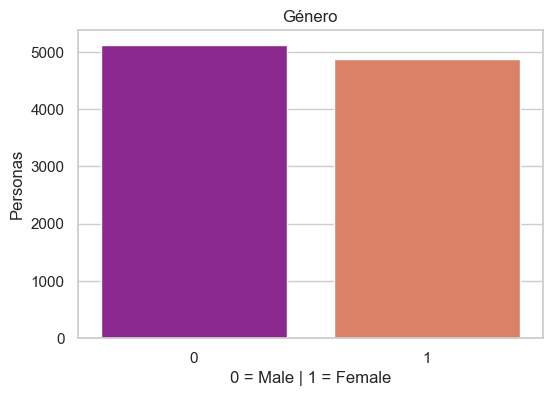

Male: 5123
Female: 4877


In [8]:
df_household["Gender_dummy"] = df_household["Gender"].map({"Female": 1, "Male": 0})

target_counts = df_household['Gender_dummy'].value_counts()

plt.figure(figsize=(6, 4))
sns.countplot(x='Gender_dummy', data=df_household, hue='Gender_dummy', palette='plasma', legend=False)
plt.title('Género')
plt.xlabel('0 = Male | 1 = Female')
plt.ylabel('Personas')
plt.show()

print(f"Male: {target_counts[0]}")
print(f"Female: {target_counts[1]}")

*Se crea una variable categorica (Gender_dummy) que toma el valor 1 para mujeres y 0 para hombres. Esta transformación permite incluir el género como predictor numérico dentro del pipeline y posteriormente analizar su efecto sobre el ingreso.*

In [9]:
target_percent = df_household['Gender_dummy'].value_counts(normalize=True) * 100
print(f"\nPorcentaje de male: {target_percent[0]:.2f}%")
print(f"Porcentaje de female: {target_percent[1]:.2f}%")


Porcentaje de male: 51.23%
Porcentaje de female: 48.77%


*En este código se observa la participación por género dentro de los datos: el 51,23 % corresponde a hombres y el 48,77 % a mujeres. Esta distribución es relativamente equilibrada, lo que evita sesgos importantes en el entrenamiento de los modelos y garantiza una representación adecuada de ambos grupos en el análisis.*

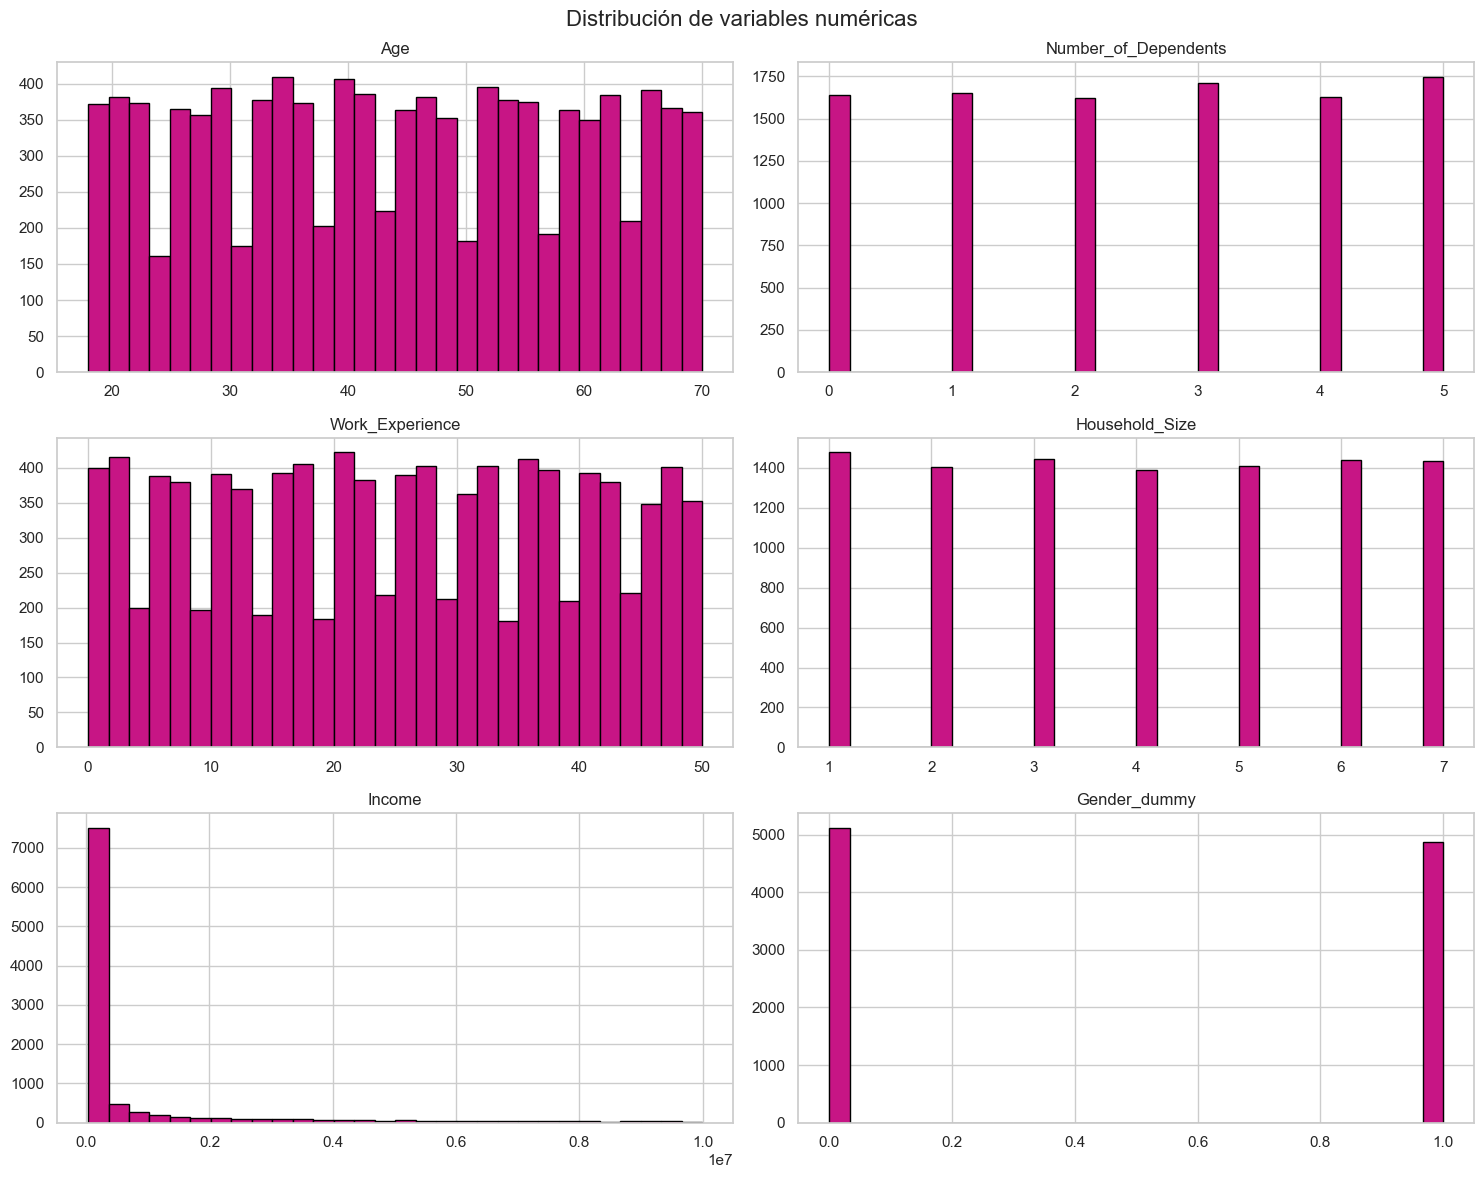

In [10]:
df_household.hist(bins=30, figsize=(15, 12), color='mediumvioletred', edgecolor="black")
plt.suptitle('Distribución de variables numéricas', fontsize=16)
plt.tight_layout()
plt.show()

*En esta figura se observa la distribución de las principales variables numéricas del conjunto de datos, la cual nos arrogó:* 

   - *Age: presenta una distribución aproximadamente uniforme entre los 18 y 70 años, lo que indica una buena representación de distintos grupos etarios.*

   - *Number_of_Dependents: está concentrada entre 0 y 5 dependientes, con una ligera mayor frecuencia en los hogares con pocos dependientes (0–2), lo que sugiere que la mayoría de los individuos tiene familias pequeñas.*

   - *Work_Experience: también muestra una distribución casi uniforme entre 0 y 50 años, lo cual refleja una amplia variedad de trayectorias laborales en la muestra.*

   - *Household_Size: está distribuida principalmente entre 2 y 6 personas, lo que representa un tamaño de hogar promedio de 4 individuos, coherente con el resultado de las estadísticas descriptivas.*

   - *Income: evidencia una fuerte asimetría positiva (sesgo a la derecha), donde la mayoría de los ingresos se concentran en valores bajos y pocos individuos alcanzan ingresos muy altos. Esto sugiere la existencia de desigualdad en los niveles de ingreso dentro del dataset.*

   - *Gender_dummy: presenta dos barras equilibradas entre 0 (hombres) y 1 (mujeres), confirmando que la muestra cuenta con una distribución casi equitativa por género (51,23 % hombres y 48,77 % mujeres).*

*En general, las variables presentan una cobertura amplia y sin valores extremos evidentes, por lo que el conjunto de datos está en condiciones adecuadas para el entrenamiento de los modelos de regresión.*

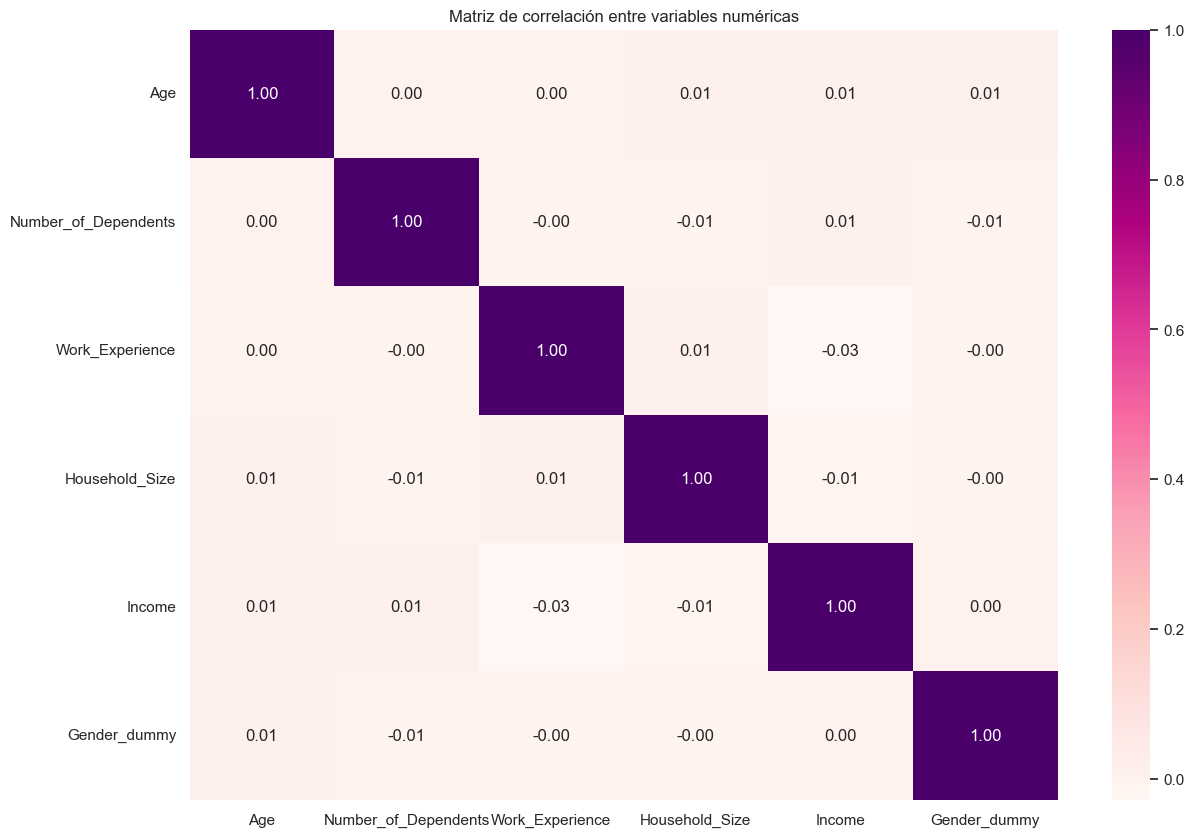

In [11]:
plt.figure(figsize=(14, 10))

# SoEspecificamos que solo para variables numéricas
num_df = df_household.select_dtypes(include=['number'])

sns.heatmap(num_df.corr(), annot=True, cmap='RdPu', fmt='.2f')
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

*Las variables numéricas presentan correlaciones bajas entre sí y con la variable objetivo (Income), lo que indica ausencia de multicolinealidad aparente dentro de este subconjunto. La correlación de Gender_dummy con el ingreso es cercana a cero, lo cual sugiere que el efecto del género no es lineal y debe analizarse en el contexto del modelo multivariado.*

##### ***PROCESAMIENTO***

In [13]:
X = df_household.drop(columns='Income', axis=1)
y = df_household['Income']

# Dividir en train y test (70%-30%)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Shape de X_train:", X_train.shape)
print("Distribución de y_train (primeras filas):\n", y_train.head())

Shape de X_train: (7000, 14)
Distribución de y_train (primeras filas):
 9069    5411144
2603      75202
7738      73714
1579      70848
5058      75474
Name: Income, dtype: int64


*El conjunto de datos se dividió en 70 % para entrenamiento y 30 % para prueba, lo que permite evaluar la capacidad de generalización de los modelos.*
*El conjunto de entrenamiento (X_train) contiene 7 000 observaciones y 14 variables predictoras, mientras que la variable objetivo (y_train) representa los niveles de ingreso de los individuos.*

*Al observar las primeras filas de y_train, se confirma que los valores de ingreso (Income) presentan una alta variabilidad, coherente con la dispersión identificada en la exploración inicial. Esto refuerza la necesidad de utilizar métricas de regresión como el RMSE para evaluar el desempeño de los modelos.*

In [14]:
# Identificamos variables numéricas y categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipelines de preprocesamiento
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer combinando ambos
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])

In [15]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Árbol de Decisión': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Regresión Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)

}

##### ***RESULTADOS***

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Diccionario de modelos de REGRESIÓN
models = {
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Árbol de Decisión": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Regresión Lineal": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

cv_scores = {}
results = {}

for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    # Validación cruzada con RMSE (negativo para sklearn)
    scores = cross_val_score(pipe, X_train, y_train, cv=5,
                             scoring='neg_root_mean_squared_error')
    cv_scores[name] = scores
    print(f"RMSE promedio (5-fold CV): {-scores.mean():.4f} ± {scores.std():.4f}")
    
    # Entrenamiento final y evaluación en test
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE en test: {rmse_test:.4f}")
    
    results[name] = {
        'pipeline': pipe,
        'rmse_test': rmse_test,
        'cv_scores': scores
    }




Entrenando modelo: KNN
RMSE promedio (5-fold CV): 1910045.8338 ± 59345.0191
RMSE en test: 1944305.4854

Entrenando modelo: Árbol de Decisión
RMSE promedio (5-fold CV): 1818914.2037 ± 69245.1389
RMSE en test: 1843159.2651

Entrenando modelo: Regresión Lineal
RMSE promedio (5-fold CV): 1807157.1588 ± 61551.0194
RMSE en test: 1836157.5897

Entrenando modelo: Random Forest
RMSE promedio (5-fold CV): 1782032.0222 ± 53388.5620
RMSE en test: 1819879.4357


*Se entrenaron y evaluaron cuatro modelos de regresión: K-Nearest Neighbors (KNN), Árbol de Decisión, Regresión Lineal y Random Forest, utilizando validación cruzada de 5 pliegues (5-fold CV).*

   - *Los resultados muestran que el modelo Random Forest obtuvo el menor error promedio (RMSE) con un valor de 1.78 millones y la menor desviación estándar (≈53 mil), lo que indica un rendimiento más estable y una mejor capacidad de generalización.*

   - *La Regresión Lineal también alcanzó un desempeño competitivo (RMSE ≈ 1.80 millones), mientras que el Árbol de Decisión y el KNN presentaron errores más altos, lo que sugiere una menor precisión en la predicción del ingreso.*

   - *En el conjunto de prueba, el Random Forest mantuvo el mejor comportamiento (RMSE = 1.81 millones), confirmando su robustez y evitando el sobreajuste.*

En términos generales, los modelos basados en árboles superaron a los modelos lineales y de vecinos cercanos, ya que pueden capturar relaciones no lineales y efectos de interacción entre las variables predictoras.

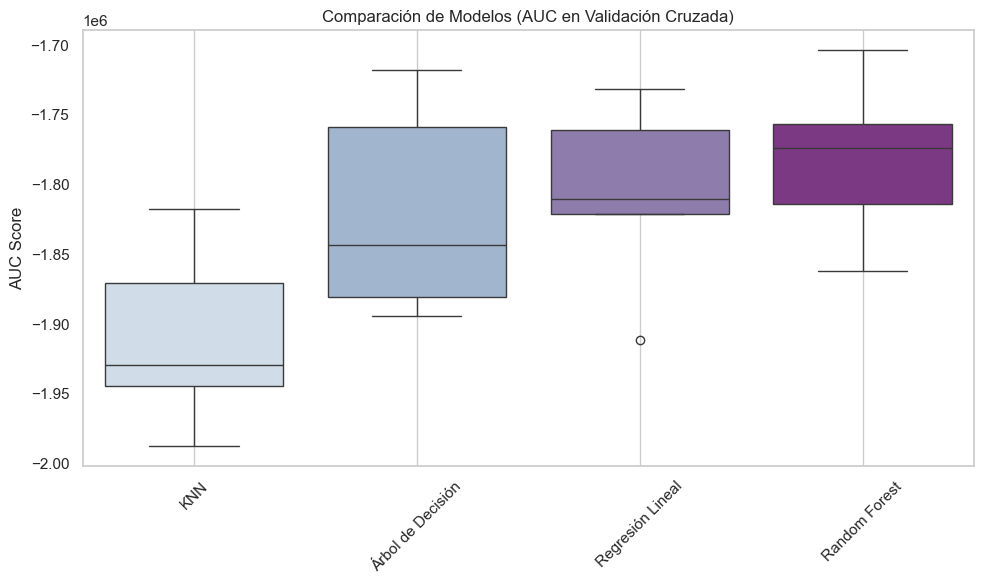

In [22]:
cv_results_df = pd.DataFrame(cv_scores)

plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_results_df, palette="BuPu")
plt.title('Comparación de Modelos (AUC en Validación Cruzada)')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

*Este gráfico, nos confirma lo de la tabla anterior, que sería:*

   - *Random Forest es el modelo con mejor rendimiento y estabilidad.*

   - *KNN es el más débil, con valores consistentemente más bajos.*

   - *Regresión Lineal ofrece un desempeño intermedio, pero con algún valor atípico.*

   - *Árbol de Decisión tiene potencial, pero muestra alta variabilidad, lo cual podría mejorarse ajustando hiperparámetros o profundizando el árbol.*